# AIN311 Introduction to Machine Learning | Term Project - Fall 2024
### Abdulkadir Parlak - 2210765025
### Talha Kaba - 2210765037

## Necessary Imports

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

In [2]:
# Paths
base_dir = "/kaggle/input/punch-detection-data-frames-scaled-180x180/Consolidated_Scaled_Data"
scaled_images_folder = "scaled_images"
scaled_annotations_file = "scaled_annotations.json"

## Dataset Loading

In [3]:
# Initialize data dictionary for grouping by label
label_groups = {}

# Load the JSON annotations
def parse_annotations(json_file):
    with open(json_file, "r") as f:
        data = json.load(f)
    
    annotations = {}
    for track in data:
        for item in track.get("tracks", []):
            label = item.get("label")
            if label:
                for shape in item.get("shapes", []):
                    frame = shape.get("frame")
                    if frame is not None:
                        image_name = f"{frame}_cropped.jpg"
                        if label not in annotations:
                            annotations[label] = []
                        annotations[label].append(image_name)
    return annotations

# Process each task folder
for task_dir in os.listdir(base_dir):
    task_path = os.path.join(base_dir, task_dir)
    if os.path.isdir(task_path):
        image_dir = os.path.join(task_path, scaled_images_folder)
        annotation_path = os.path.join(task_path, scaled_annotations_file)
        
        if not os.path.exists(image_dir) or not os.path.exists(annotation_path):
            continue
        
        frame_annotations = parse_annotations(annotation_path)
        
        for label, image_names in frame_annotations.items():
            if label not in label_groups:
                label_groups[label] = {'images': [], 'labels': []}
            
            for image_name in image_names:
                image_path = os.path.join(image_dir, image_name)
                if os.path.exists(image_path):
                    img = load_img(image_path, target_size=(180, 180))
                    img_array = img_to_array(img) / 255.0
                    label_groups[label]['images'].append(img_array)
                    label_groups[label]['labels'].append(label)

# Map labels to integers
classes = [
    "Head with left hand", "Head with right hand", 
    "Body with left hand", "Body with right hand",
    "Block with left hand", "Block with right hand",
    "Miss with left hand", "Miss with right hand"
]
class_to_index = {cls: idx for idx, cls in enumerate(classes)}

# Split by label groups
train_images, train_labels = [], []
val_images, val_labels = [], []

for label, group in label_groups.items():
    group_images = np.array(group['images'], dtype=np.float32)
    group_labels = np.array([class_to_index[label]] * len(group['images']), dtype=np.int32)
    
    X_train, X_val, y_train, y_val = train_test_split(
        group_images, group_labels, test_size=0.2, random_state=42
    )
    
    train_images.extend(X_train)
    train_labels.extend(y_train)
    val_images.extend(X_val)
    val_labels.extend(y_val)

train_images = np.array(train_images, dtype=np.float32)
train_labels = np.array(train_labels, dtype=np.int32)
val_images = np.array(val_images, dtype=np.float32)
val_labels = np.array(val_labels, dtype=np.int32)

## CNN Model

In [4]:
# Define the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=90, kernel_size=(3, 3), activation='relu', input_shape=(180, 180, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=180, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=180, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=180, activation='relu'),
    tf.keras.layers.Dense(units=8, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Model Training

In [5]:
# Train the model
history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=10,
    batch_size=32
)

Epoch 1/10


I0000 00:00:1735127623.196444     554 service.cc:145] XLA service 0x7bf034005d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735127623.196525     554 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-12-25 11:53:49.069581: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[180,90,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,90,89,89]{3,2,1,0}, f32[32,180,87,87]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-25 11:53:49.425207: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.355733783s
Trying algorithm eng0{} for conv (f32[180,90,3

  3/452 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - accuracy: 0.1944 - loss: 6.4848 

I0000 00:00:1735127632.042367     554 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


452/452 ━━━━━━━━━━━━━━━━━━━━ 43s 72ms/step - accuracy: 0.3093 - loss: 2.0369 - val_accuracy: 0.3315 - val_loss: 1.7861
Epoch 2/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.3307 - loss: 1.7806 - val_accuracy: 0.3315 - val_loss: 1.7629
Epoch 3/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.3577 - loss: 1.7118 - val_accuracy: 0.4081 - val_loss: 1.5818
Epoch 4/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.4494 - loss: 1.4748 - val_accuracy: 0.5270 - val_loss: 1.3239
Epoch 5/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.5916 - loss: 1.1261 - val_accuracy: 0.6414 - val_loss: 1.0568
Epoch 6/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.7206 - loss: 0.7919 - val_accuracy: 0.7385 - val_loss: 0.8327
Epoch 7/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.8164 - loss: 0.5279 - val_accuracy: 0.7722 - val_loss: 0.7673
Epoch 8/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.8539 - loss: 0.4384 - val_accurac

## Model Evaluation

In [14]:
# Evaluate the model
loss, accuracy = model.evaluate(val_images, val_labels)
print(f"Final Validation Loss: {loss:.4f}")
print(f"Final Validation Accuracy: {accuracy:.4f}")

114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8379 - loss: 0.6095
Final Validation Loss: 0.7268
Final Validation Accuracy: 0.8084


## Save the Model

In [13]:
# Save the model in HDF5 format
model.save('punch_detection_model.h5')
print("Model saved as punch_detection_model.h5")

Model saved as punch_detection_model.h5


## Performance Metrics Visualizations

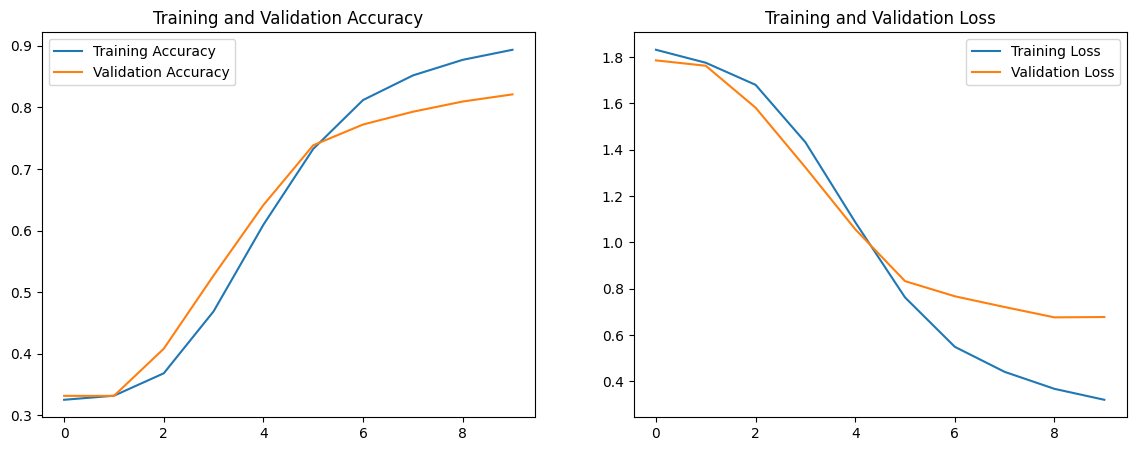

In [7]:
# 🟦 1. Plot Training and Validation Accuracy/Loss
def plot_training_history(history):
    epochs = range(len(history.history['accuracy']))

    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_training_history(history)

114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
🔹 Accuracy: 0.8084
🔹 Precision: 0.8091
🔹 Recall: 0.8084
🔹 F1 Score: 0.8072
📑 Classification Report:
                        precision    recall  f1-score   support

  Head with left hand       0.81      0.84      0.83      1199
 Head with right hand       0.76      0.86      0.81       605
  Body with left hand       0.65      0.59      0.62       123
 Body with right hand       0.72      0.50      0.59       107
 Block with left hand       0.90      0.85      0.88       251
Block with right hand       0.89      0.81      0.85       139
  Miss with left hand       0.85      0.81      0.83       776
 Miss with right hand       0.80      0.76      0.78       417

             accuracy                           0.81      3617
            macro avg       0.80      0.75      0.77      3617
         weighted avg       0.81      0.81      0.81      3617



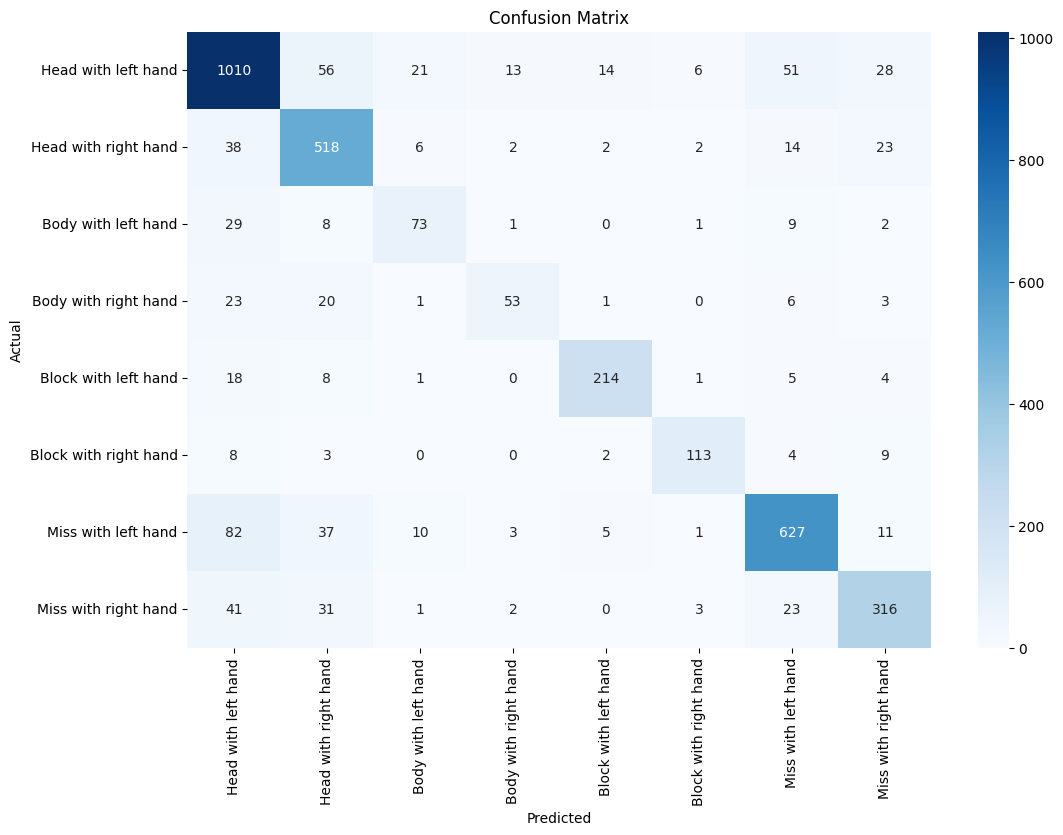

In [8]:
# Load the saved model (adjust path if needed)
model = load_model('/kaggle/working/punch_detection_model.h5')

# Make predictions
y_pred = model.predict(val_images)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices


# Calculate Accuracy
accuracy = accuracy_score(val_labels, y_pred_classes)

# Calculate Precision, Recall, and F1-Score
precision = precision_score(val_labels, y_pred_classes, average='weighted')
recall = recall_score(val_labels, y_pred_classes, average='weighted')
f1 = f1_score(val_labels, y_pred_classes, average='weighted')

# Display Metrics
print(f"🔹 Accuracy: {accuracy:.4f}")
print(f"🔹 Precision: {precision:.4f}")
print(f"🔹 Recall: {recall:.4f}")
print(f"🔹 F1 Score: {f1:.4f}")


# Generate a full classification report
report = classification_report(val_labels, y_pred_classes, target_names=classes)
print("📑 Classification Report:\n", report)


# Plot Confusion Matrix
cm = confusion_matrix(val_labels, y_pred_classes)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


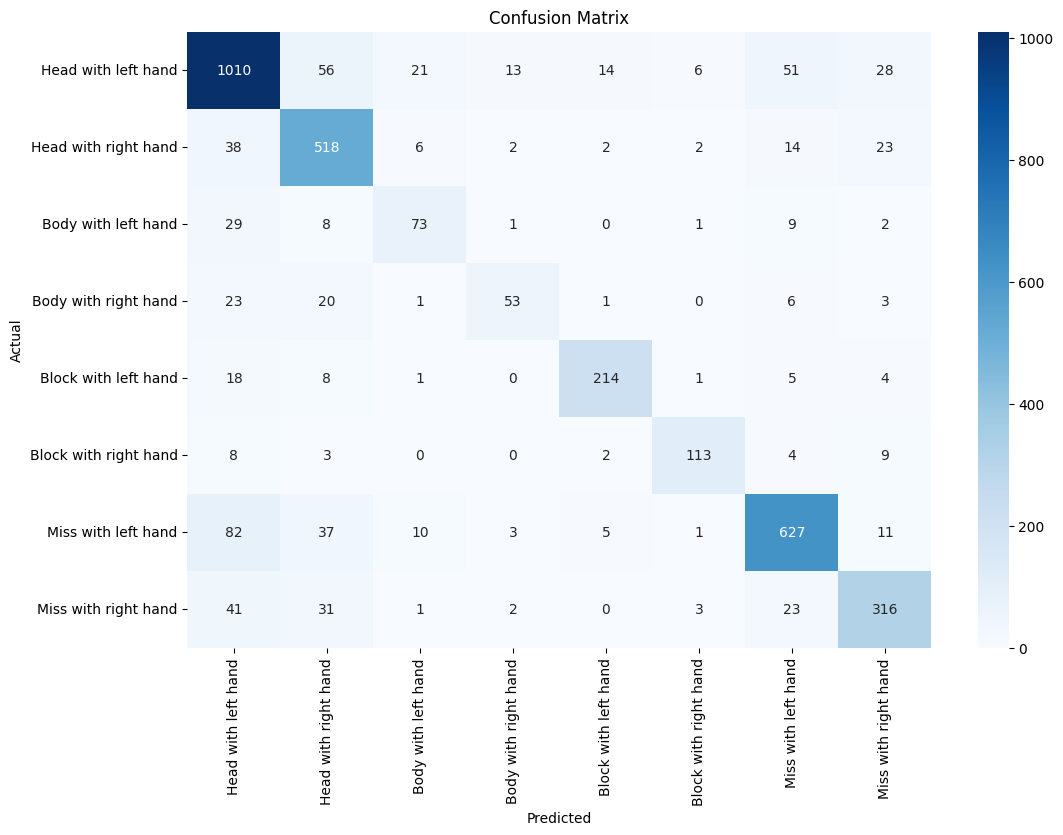

In [9]:
# 🟩 2. Plot Confusion Matrix
def plot_confusion_matrix(model, images, labels, classes):
    predictions = np.argmax(model.predict(images), axis=1)
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(model, val_images, val_labels, classes)

## Model Architecture Visualization

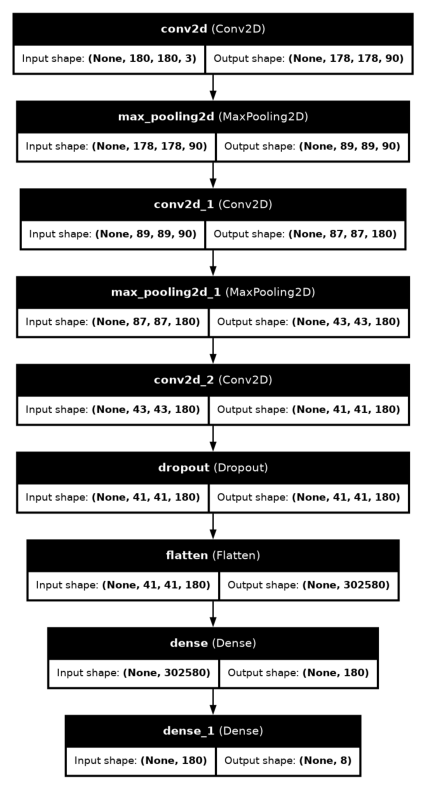

In [10]:
# 🟥 3. Plot Model Architecture
plot_model(
    model,
    to_file='model_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    dpi=96
)

# Display Model Architecture Image
img = Image.open('model_architecture.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()